I. Petrov, A. Buzmakov, L. Samoylova, 09.12.2019, European XFEL

This notebook simulates difraction of a Gaussian pulse in a crystal

In the current version "up" and "down" surface orientation for Bragg case and "up" surface orientation for Laue case are implemented

/gpfs/exfel/data/user/petrovi/WPG_Xtal_pub/ here is the version of WPG with implemented crystal diffraction

In [1]:
from __future__ import print_function #Python 2.7 compatibility
from __future__ import absolute_import

from __future__ import division
from __future__ import unicode_literals

import sys
sys.path.insert(0, '../..')

import numpy as np
import pylab as plt
import os
import matplotlib
import glob

#to get data from x-server
import urllib
import requests
import re

from wpg.srwlib import srwl
from wpg.srwlib import *
from wpg import Beamline, optical_elements
from wpg.optical_elements import Drift, Use_PP
from wpg.wavefront import Wavefront
from wpg.generators import build_gauss_wavefront

from wpg.useful_code.wfrutils import show_slices_hsv
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calculate_fwhm, show_profile, time_en_int, integral_intensity

In [2]:
#define Gaussian pulse parameters
#mean photon energy
ph_en_kev = 9
#coherence time, which definces the width of spectrum
coherence_time_fs = 0.2
#beam size at monochromator, beam divergence 2 urad by default
beamsize_um = 500

In [3]:
#crystal parameters
manual_input=0
element='Silicon' #as in Crystal field here https://x-server.gmca.aps.anl.gov/cgi/www_form.exe?template=x0h_form.htm
hkl = [1,1,1]
thickness = 0.1e-3 #in meters

In [4]:
def gauss_wfr_def(w=beamsize_um*1e-6,tau_c=coherence_time_fs,ph_en=ph_en_kev):
    beam_ph_en = ph_en #Gaussian beam mean photon energy
    pulseInt = 1e-3 #pulse intensity
    coh_time = tau_c*1e-15  #coherence time, s
    theta_fwhm =2.0e-6  #angular divergence, rad
    num_points = 400  #number of points in in transverse direction
    nslices = 100     #number of points in time
    sig_num = 5.5     #number of sigmas in transverse direction

    wlambda = 12.4*1e-10/beam_ph_en
    omega0 = 2*np.pi*3*1e8/wlambda
    w0 = wlambda/(np.pi*theta_fwhm) 
    w0_a = w0/(2*np.sqrt(np.log(2)))
    zR = (np.pi*w0_a**2)/wlambda 
    src_oe1 = zR*np.sqrt((w/w0)**2-1)    #distance from source, m
    range_xy = w0_a * np.sqrt(1+(src_oe1/zR)**2)/np.sqrt(2)*sig_num
    

    wfr = build_gauss_wavefront(num_points, num_points, nslices, \
    beam_ph_en,-range_xy/2,range_xy/2, -range_xy/2, range_xy/2,
    coh_time/np.sqrt(2), w0_a, w0_a, src_oe1, pulseEn=pulseInt, pulseRange=20.)
    
    return wfr

In [5]:
def xtal(element='Silicon',hkl=[1,1,1],asymAngle=0.0,thickness=0.1e-3,orient_ph_en=12.4,\
         case='Bragg',isDiffr=1,vertDiffr=1,\
         manual=0,chi0=0+0*1j,chih=0+0*1j,d=0,faceUpDown=0):
    """
    :param faceUpDown: 0 - face up, 1 - face down
    """
    if case == 'Bragg':
        if isDiffr == 1:
            uc = 1
        else:
            uc = 2
    elif case == 'Laue':
        if isDiffr == 1:
            uc = 3
        else:
            uc = 4
    if manual:
        dSp = d
        psi0r = np.real(chi0)
        psi0i =  np.imag(chi0)
        psihr = np.real(chih)
        psihbi = np.imag(chih)
        psihbr = psihr; psihbi = psihi 
    else:
        data1 = {
            'code': element,'xway': '2','wave': str(orient_ph_en),'line': '','coway': '0','amor': '','chem': '',\
            'rho': '','i1': str(hkl[0]),'i2': str(hkl[1]),'i3': str(hkl[2]),'df1df2': '-1','modeout': '1','detail': '0'}
        response1 = requests.get('https://x-server.gmca.aps.anl.gov/cgi/x0h_form.exe', params = data1)
        r1 = str(re.findall(r'\sd=\s*[.\d]*',response1.text)[0])
        r2 = str(re.findall(r'\sxr0=-*[.\d]*E*-*[.\d]*',response1.text)[0])
        r3 = str(re.findall(r'\sxi0=-*\s*[.\d]*E*-*[.\d]*',response1.text)[0])
        r4 = str(re.findall(r'\sxrhsg=-*\s*[.\d]*E*-*[.\d]*',response1.text)[0])
        r5 = str(re.findall(r'\sxihsg=-*\s*[.\d]*E*-*[.\d]*',response1.text)[0])
        dSp = float(r1[len(' d= ')+1:])
        psi0r = float(r2[len(' d= ')+1:])
        psi0i = float(r3[len(' d= ')+1:])
        psihr = -float(r4[len(' d= ')+3:])
        psihi = float(r5[len(' d= ')+3:])
    thickCryst = thickness
    angAsCryst = asymAngle
    
    opCr1 = SRWLOptCryst(_d_sp=dSp, _psi0r=psi0r,_psi0i=psi0i,\
    _psi_hr=psihr, _psi_hi=psihi,_psi_hbr=psihr, _psi_hbi=psihi,\
                         _tc=thickCryst, _ang_as=angAsCryst,_uc=uc)
    
    opCr1.find_orient_and_rotate_faceUpDown(en_kev=orient_ph_en,UpDown=faceUpDown)
    
    return opCr1

In [6]:
def Xtal_element(opCr):
    prPar1 =    [0, 0, 1.0, 0, 0, 1.0,  1.0,    1.0,    1.0, 0, 0, 0]
    return SRWLOptC([opCr], [prPar1])

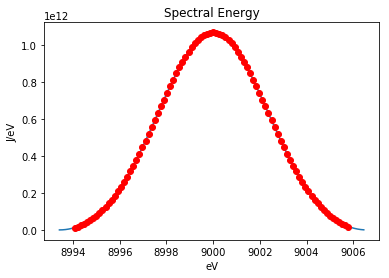

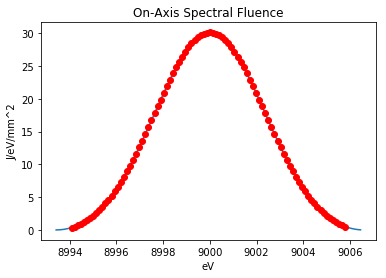

number of meaningful slices: 90


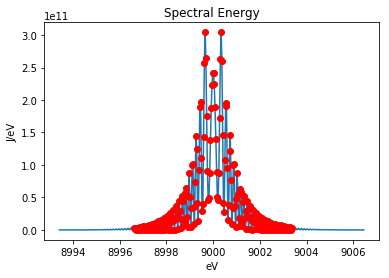

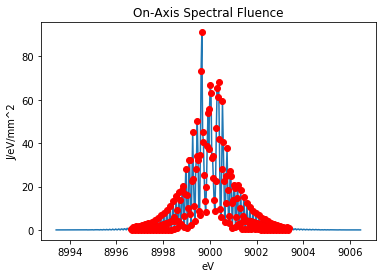

number of meaningful slices: 208


43738192029.53846

In [7]:
#Laue reflection, faceUpDown==0 for face 'up', faceUpDown==1 for face 'down'
opCr1 = xtal(element=element,hkl=hkl,case='Laue',\
                   thickness=thickness,orient_ph_en=ph_en_kev,faceUpDown=0)
optBL_Xtal_Laue_refl = Xtal_element(opCr1)

wf = Wavefront(gauss_wfr_def(w=beamsize_um,ph_en=ph_en_kev,tau_c=coherence_time_fs))
srwl.ResizeElecField(wf._srwl_wf, 't', [0.0,10.0,0.1])
srwl.SetRepresElecField(wf._srwl_wf, 'f')
integral_intensity(wf)
srwl.ResizeElecField(wf._srwl_wf, 't', [0.0,1.0,4.0])
srwl.PropagElecField(wf._srwl_wf,optBL_Xtal_Laue_refl)
integral_intensity(wf)

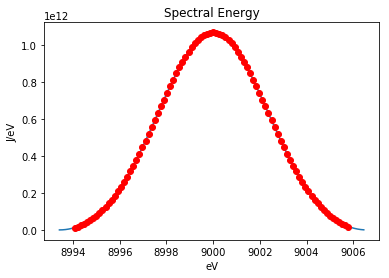

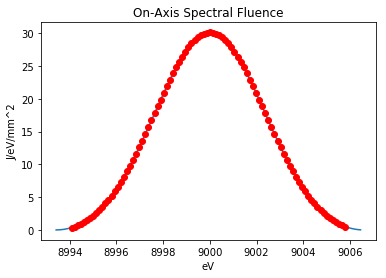

number of meaningful slices: 90


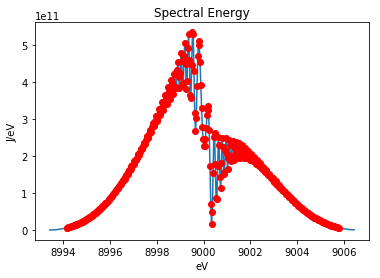

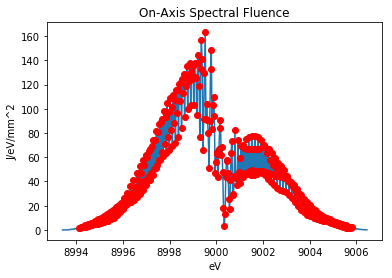

number of meaningful slices: 358


167072461051.7095

In [8]:
#Laue transmission
opCr1 = xtal(element=element,hkl=hkl,case='Laue',\
                   thickness=thickness,orient_ph_en=ph_en_kev,faceUpDown=0,isDiffr=0)
optBL_Xtal_Laue_transm = Xtal_element(opCr1)
wf = Wavefront(gauss_wfr_def(w=beamsize_um,ph_en=ph_en_kev,tau_c=coherence_time_fs))
srwl.ResizeElecField(wf._srwl_wf, 't', [0.0,10.0,0.1])
srwl.SetRepresElecField(wf._srwl_wf, 'f')
integral_intensity(wf)
srwl.ResizeElecField(wf._srwl_wf, 't', [0.0,1.0,4.0])
srwl.PropagElecField(wf._srwl_wf,optBL_Xtal_Laue_transm)
integral_intensity(wf)